In [ ]:
!pip install influxdb-client

In [1]:
import influxdb_client
import pandas as pd
import matplotlib.pyplot as plt

# Data retrieval

In [2]:
org="2684bd5f2421cb07"
bucket = "labinformatics HU2022"

client = influxdb_client.InfluxDBClient(
    url='https://eu-central-1-1.aws.cloud2.influxdata.com',
    token='vSqR-lzePjp98WqlrlQa03f4fULu0MeumLVjId5_COSdbY2amYdNu0f891QPkS0Rt1wMvAPYAyh0FoV4aZX3Ig==',
    org=org)

# Querying the data

In [3]:
query_api = client.query_api()

query = f'from(bucket:"{bucket}")\
    |> range(start: 0, stop: now())\
    |> filter(fn: (r) => r._measurement == "LDR_status")\
    |> filter(fn: (r) => r._field == "LDR")\
    |> filter(fn: (r) => r.device == "ESP8266")\
    |> filter(fn: (r) => r.LDR == "Sensor 1")'

result = query_api.query(org=org, query=query)

results = []
for table in result:
  for record in table.records:
    results.append((record.get_field(), record.get_value(), record.get_time(), record.values.get("device")))

df = pd.DataFrame(results, columns=['field', 'value', 'time', 'device'])

# Statistical overview

In [36]:
statistical_overview = df.groupby('field')['value'].describe()
print(statistical_overview)

# Maxima
maxima = df.groupby('field')['value'].max()
print(f"Maximum LDR value: {maxima.LDR}\n")

# Minima
minima = df.groupby('field')['value'].min()

# Mean
mean = df.groupby('field')['value'].mean()

         count        mean        std  min   25%    50%    75%     max
field                                                                 
LDR    31940.0  262.157232  263.17856  7.0  14.0  200.0  427.0  1024.0
Maximum LDR value: 1024



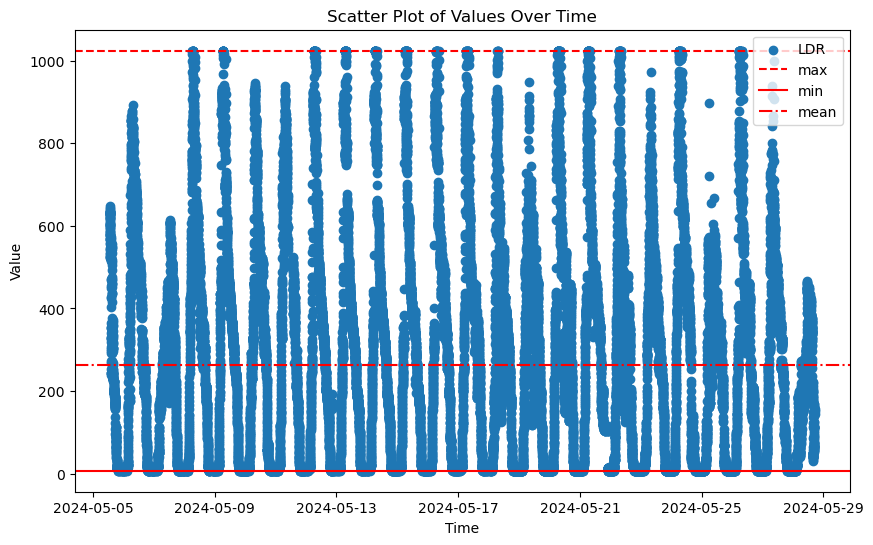

In [37]:
# Scatter plot
plt.figure(figsize=(10, 6))
for field, data in df.groupby('field'):
    plt.scatter(data['time'], data['value'], label=field)
    if data['value'].max() == maxima.LDR:
        plt.axhline(y=maxima.LDR, color='r', linestyle='--', label='max')
    if data['value'].min() == minima.LDR:
        plt.axhline(y=minima.LDR, color='r', linestyle='-', label='min')
    if data['value'].mean() == mean.LDR:
        plt.axhline(y=mean.LDR, color='r', linestyle='-.', label='mean')
        
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Scatter Plot of Values Over Time')
plt.legend()
plt.show()

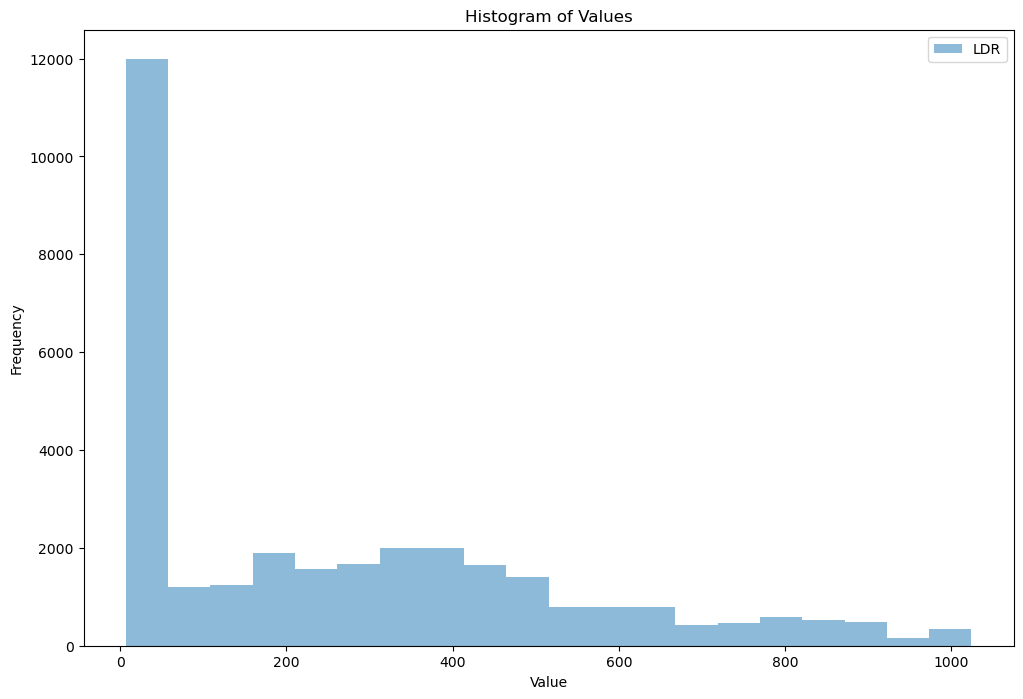

In [38]:
# Histograms
plt.figure(figsize=(12, 8))
for field, data in df.groupby('field'):
    plt.hist(data['value'], bins=20, alpha=0.5, label=field)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Values')
plt.legend()
plt.show()